![](./images/Title_ex_6.6.png)

# 1. Introduction

In the previous exercises we explored different online data portals and analysis techniques to investigate vegetation and droughts. In this notebook we will put everything together in one use case and look at how vegetation production in a certain agricultural region is impacted by drought and how many people are likely to be directly impacted by that drought. We will be using the **Vegetation Health Index** from the [ASIS data portal](https://www.fao.org/giews/earthobservation/asis/index_1.jsp?lang=en) to look into a specific drought and its impact on vegetation.
For more details on the methodology used to derive this index, have a look at [this paper](https://www.tandfonline.com/doi/full/10.1080/01431161.2015.1126378?scroll=top&needAccess=true).

The **Vegetation Health Index (VHI)** illustrates the severity of drought based on the vegetation health and the influence of temperature on plant conditions. The VHI is a composite index, combining the Vegetation Condition Index (VCI) and the Temperature Condition Index (TCI). VCI evaluates the current vegetation health in comparison to historical trends by relating the current dekadal NDVI to its long-term minimimum and maximum value. The TCI is calculated using a similar equation to the VCI, but relates the current temperature to the long-term maximum and minimum , as it is assumed that higher temperatures tend to cause a deterioration in vegetation conditions. A decrease in the VHI would, for example, indicate relatively poor vegetation conditions and warmer temperatures, signifying stressed vegetation conditions, and over a longer period would be indicative of drought.

Within ASIS, VHI is available as a dekadal, monthly and annual metric. An interesting derived product is the **Mean Vegetation Health Index (MVHI)**, available per dekad and per season. For each pixel, this MVHI represents the temporally averaged VHI starting from the start of season up to the requested dekad and provides a good indication on drought conditions during a growing season of interest.

In the scope of this use case, we will only focus on one (the first) growing season. During a typical growing season, a crop is most sensitive to a drought event during the first half of the season, when the crop is fully developing. Therefore, we will zoom in on the first half of the growing season and derive the MVHI for each pixel at the moment of the peak of the season (this moment could be different for different pixels!). For each pixel, we will be needing information on the timing of the peak of season, which we will get through the WaPOR phenology products.

Based on the MVHI value, the growing season can be classified into different drought severity classes:

- Class 1: MVHI < 0.25    : Extreme
- Class 2: MVHI 0.25-0.35 : Severe
- Class 3: MVHI 0.35-0.38 : Moderate 
- Class 4: MVHI 0.38-0.42 : Mild
- Class 5: MVHI 0.42-1    : None
- Class 6: MVHI > 1       : Insufficient data

Once we derived these drought severity classes for our area of interest, we will be checking the impact of the drought on vegetation productivity in the most affected area by inspecting the biomass productivity metrics as provided through the WaPOR portal.

Finally, we will also be looking at the number of people affected by drought. For this, we can make use of the WPOP database, providing numbers of population density throughout the world and also available through the FAO API.



**Throughout the notebook, we ask a series of QUESTIONS. Reflect upon these, collect your answers in one WORD document and submit to the teaching staff. This part is mandatory in order to pass the course.**



Notebook outline: 
- [1. Introduction](#1.-Introduction)
- [2. Libraries](#2.-Import-the-necessary-libraries)
- [3. Choose a drought event and location](#3.-Choose-a-drought-event-and-location)
- [4. Extract land cover information](#4.-Land-cover-mask)
- [5. Extract phenology](#5.-Extract-phenology)
- [6. Get mean VHI](#6.-Get-mean-VHI)
- [7. Calculate another index for this region](#7.-Calculate-another-index-for-this-region)
- [8. Impact of drought on vegetation](#8.-Impact-of-drought-on-vegetation)
- [9. How many people are affected?](#9.-How-many-people-are-affected?)


# 2. Import the necessary libraries

In [1]:
import requests
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os 
import json
from pathlib import Path
import cdsapi
import rioxarray
import xarray as xr
import numpy as np
from osgeo import gdal
import glob
from shapely.geometry import Polygon

# 3. Choose a drought event and location

First we need to choose a drought event of which we want to investigate the impact from. NASA's GRACE sensor provides coarse resolution information on Surface Soil Moisture, Root Zone Soil Moisture and Groundwater levels. This information can be accessed [HERE](https://nasagrace.unl.edu/Archive.aspx) to get a first impression on when and where dry conditions are occuring.

Based on this information, we have already identified a potentially interesting drought event in the 2015 growing season of the Gadaref region in Sudan. Compared to 2015, 2018 has been a relatively wet year in the same region. Throughout this exercise we will compare both periods in this region and check whether we can see any impact of the drought on vegetation productivity.

To delineate the region of interest to which we are going to clip our data we can make use of the FAO Global Administrative Unit Layer (GAUL) database which provides shapefiles for each departement within all countries.

The GAUL dataset can be found in the folder ./data/GAUL. Different levels of detail exist: level 0 represents the country borders, level 1 represents the departement borders and level 2 (not provided here) goes up to province level. Feel free to inspect these shapefiles in QGIS to get familiar with the data.

From the level 1 dataset, we will first isolate our country of interest (Sudan).

In [3]:
country = 'Sudan'
gaul1_file = './data/GAUL/GAUL1_thinned.shp'

gaul1 = gpd.read_file(gaul1_file)

sudan = gaul1.loc[gaul1['ADM0_NAME'] == country]

outdir = Path('./results')
outdir.mkdir(exist_ok=True)

outfile = str(outdir / 'Sudan.gpkg')
sudan.to_file(outfile, driver='GPKG')

Plot the country of interest and look at which departments are available:

,ADM1_CODE,ADM1_NAME,STR1_YEAR,EXP1_YEAR,STATUS,DISP_AREA,ADM0_CODE,ADM0_NAME,Shape_Leng,Shape_Area,geometry
477,2745,Al Jazeera,1994,3000,Member State,NO,6,Sudan,10.195142,1.996427,"POLYGON ((33.64067 15.31577, 34.01519 15.18538..."
478,2749,Blue Nile,1994,3000,Member State,NO,6,Sudan,8.866905,3.125260,"POLYGON ((34.47623 12.55284, 34.65802 12.51429..."
479,2753,Khartoum,1000,3000,Member State,NO,6,Sudan,7.145830,1.841496,"POLYGON ((32.11407 16.45235, 32.18403 16.39988..."
480,2755,Northern,1994,3000,Member State,NO,6,Sudan,29.929447,31.293111,"POLYGON ((31.41221 22.00778, 32.41229 22.00094..."
481,2757,Northern Darfur,1994,3000,Member State,NO,6,Sudan,27.515367,26.771089,"POLYGON ((26.20681 20.00610, 27.49695 20.00562..."
482,2761,Nile,1994,3000,Member State,NO,6,Sudan,17.836519,10.977293,"POLYGON ((33.56318 21.72604, 33.25849 21.51465..."
483,2762,Sennar,1994,3000,Member State,NO,6,Sudan,11.869203,3.341615,"POLYGON ((33.82103 14.04371, 34.01282 13.98661..."
484,2764,Southern Darfur,1994,3000,Member State,NO,6,Sudan,19.548674,11.421107,"POLYGON ((24.45512 13.10490, 24.75710 13.09588..."
485,2769,Western Darfur,1994,3000,Member State,NO,6,Sudan,15.196735,4.626362,"POLYGON ((22.84261 14.91736, 22.87306 14.88714..."
486,2770,White Nile,1994,3000,Member State,NO,6,Sudan,12.787100,3.411092,"POLYGON ((32.66610 15.24872, 32.77079 14.99412..."


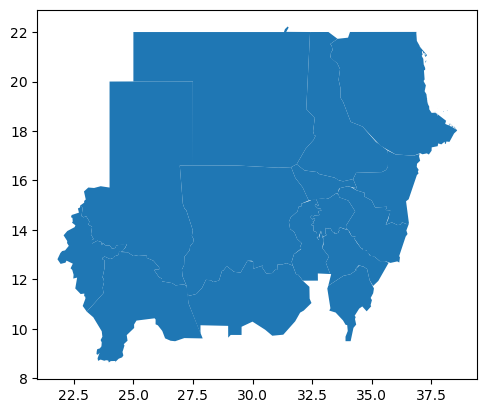

In [4]:
sudan.plot()
sudan

Now create a new shapefile with just the departement of Gadaref. This will be our Region of Interest (ROI) for the remainder of this exercise.

In [5]:
department = 'Gadaref'

roi = sudan.loc[sudan['ADM1_NAME'] == department]
outfile = str(outdir / 'ROI.gpkg')
roi.to_file(outfile, driver='GPKG')

# 4. Land cover mask

In order to focus our analysis just on cropland and grassland, we need land cover information for our region of interest...

## 4.1 Download data from WaPOR

We will use the Copernicus Global Land Cover product available through the WaPOR data portal.

Download the **100m version** of this product for our region of interest for both the wet (2018) and dry (2015) years.

Make use of the **request_tif_files** function from exercise 6.2.3, but this time use the ROI shapefile as input for the function.

In [17]:
def request_tif_files(workspace, product_code, crs,
                      outputfilename, dimensions,
                      shapefile=None, labelcol=None,
                      bbox=None):
    '''
    Function to extract .tif files for one or multiple polygons from the FAO portal.
    
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
   
    - crs: EPSG code of projection system (int)
    - dimensions: list of dimensions specifying the characteristics of the exact product
      you wish to download.
    
    For spatial information, you can either provide a shapefile or a series of bounding boxes:
    - shapefile: path to shapefile containing one or multiple polygons for which data
      needs to be extracted.
    - labelcol: this parameter is only required if "shapefile" is provided and represents
      the name of the column in the shapefile which serves as a unique identifier for
      the polygons.
    - bbox: dictionary with keys representing label of the bbox
        and values the actual bounding box in the CRS defined by the next parameter and
        in the format [xmin, ymin, xmax, ymax].
        
    The function will return a list of download links.
    '''
    
    # define necessary paths to the service
    path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
    path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

    # request API token
    APIToken = input('Your API token: ')
    # get access token
    resp_signin = requests.post(path_sign_in,
                              headers={'X-GISMGR-API-KEY': APIToken})
    resp_signin = resp_signin.json()
    AccessToken = resp_signin['response']['accessToken']
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # prepare spatial information, either from bbox or shapefile...
    crs = f'EPSG:{crs}'
    shapes = {}
    if bbox is not None:
        npoly = len(bbox.keys())
        for name, box in bbox.items():
            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            shape = [
                    [xmin,ymin],
                    [xmin,ymax],
                    [xmax,ymax],
                    [xmax,ymin],
                    [xmin,ymin]
                    ]
            shapes[name] = [shape]
            
    elif shapefile is not None:
      polys = gpd.read_file(shapefile)
      npoly = len(polys)
      names = polys[labelcol].values
      geometry = json.loads(polys.geometry.to_json())['features']
      for k, name in enumerate(names):
        shapes[name] = geometry[k]['geometry']['coordinates']

    else:
        raise ValueError('No spatial information provided!')
    
    print('Sending query for each polygon...')
    output = []
    i = 0    
    for label, geom in shapes.items():
      
      print(f'Processing polygon {i+1} / {npoly}...')
      
      # build query
      query = {
      "type": "CropRaster",
      "params": {
        "properties": {
          "outputFileName": outputfilename,
          "cutline": True,
          "tiled": True,
          "compressed": True,
          "overviews": True
        },
        "cube": {
          "code": product_code,
          "workspaceCode": workspace,
          "language": "en"
        },
        "dimensions": dimensions,
        "measures": [
          measure
        ],
        "shape": {
          "type": "Polygon",
          "properties": {
              "name": crs},
          "coordinates": geom}}}
      
      # Post query
      resp_query = requests.post(path_query,
                                 headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                 json=query)
      resp_query = resp_query.json()
      job_url = resp_query['response']['links'][0]['href']
      
      # Get results
      j = 0
      print('RUNNING', end=" ")
      while j == 0:        
          resp = requests.get(job_url)
          resp = resp.json()
          if resp['response']['status']=='RUNNING':
              print('.', end =" ")
          if resp['response']['status']=='COMPLETED':
              results = resp['response']['output']
              out = results['downloadUrl']
              j = 1
          if resp['response']['status']=='COMPLETED WITH ERRORS':
              print(resp['response']['log'])
              out = None
              j = 1
      
      output.append(out)

    return output

In [18]:
product_code = 'L2_LCC_A'
workspace = 'WAPOR_2'

years = {'dry': 2015,
         'wet': 2018}

crs = 4326
roifile = outfile
labelcol = 'ADM1_NAME'

for label, year in years.items():
    outputfilename = f'L2_LCC_{label}_clipped.tif'
    year_input = f'[{year}-01-01,{year+1}-01-01)'
    dimensions = [{"code": "YEAR",
                   "values": [year_input]}]
    output = request_tif_files(workspace, product_code,
                               crs, outputfilename,
                               dimensions, shapefile=roifile,
                               labelcol=labelcol)
    print(output)

MEASURE:  LCC
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/48c51b95-054b-41ab-b9a3-9d3a3b364e03/L2_LCC_dry_clipped.tif']
MEASURE:  LCC
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/1df5761c-3b40-4761-bc71-6f13dcaa6c49/L2_LCC_wet_clipped.tif']


QUESTION: does the land cover information available through WaPOR already reflect the difference in climatological conditions between both years? If yes, how?

## 4.2 Create the mask

We only want to focus our analysis on **grassland and cropland**. Create a mask based on both land cover products containing "1" for pixels of interest and NaN for other pixels.

In [19]:
infiles = {'wet': './results/LC/L2_LCC_wet_clipped.tif',
           'dry': './results/LC/L2_LCC_dry_clipped.tif'}

for t, infile in infiles.items():
    lcc = rioxarray.open_rasterio(infile)
    lcc_masked = lcc.where(lcc.isin([30,41,42,43]))
    lcc_binary = lcc_masked.where(np.isnan(lcc_masked), 1)
    # export final mask to tiff file
    outfile = f'./results/LC/L2_LCC_{t}_masked.tif'
    lcc_binary.rio.to_raster(outfile)

# 5. Extract phenology

Phenology metrics will be extracted from the WaPOR database. 

For this exercise we are interested in the maximum of season (MOS), as this will define for each pixel up till when we need to compute the Mean Vegetation Health Index...

Download this indicator for our region of interest and both the wet and dry year. Do this for both season 1 and 2 (S1 and S2).

Make use of the **request_tif_files** function from exercise 6.2.3, but this time use the ROI shapefile as input for the function.

In [20]:
product_code = 'L2_PHE_S'
workspace = 'WAPOR_2'

years = {'dry': "[2015-01-01,2016-01-01)",
         'wet': "[2018-01-01,2019-01-01)"}
stages = ['MOS']
seasons = ["S1", "S2"]

crs = 4326

for season in seasons:
    for name, year in years.items():
        for stage in stages:
            outputfilename = f'L2_PHE_{name}_{stage}_{season}.tif'
            dimensions = [{"code": "SEASON",
                           "values": [season]},
                          {"code": "STAGE",
                           "values": [stage]},
                          {"code": "YEAR",
                           "values": [year]}]
            output = request_tif_files(workspace, product_code,
                                       crs, outputfilename,
                                       dimensions, shapefile=roifile,
                                       labelcol=labelcol)
            print(output)


MEASURE:  PHE
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/ddd55dfe-5fb3-4dd8-81a6-76f9e5aa0c4c/L2_PHE_dry_MOS_S1.tif']
MEASURE:  PHE
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/657e3cab-2995-451f-b1de-d04cd79662bb/L2_PHE_wet_MOS_S1.tif']
MEASURE:  PHE
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/6d99b363-561c-4046-a073-1d3bfc4d86f0/L2_PHE_dry_MOS_S2.tif']
MEASURE:  PHE
Sending query for each polygon...
Processin

Upload the downloaded files into a designated folder *phenology* in your results directory (./results/phenology).

## 5.2 Check results visually and extract relevant information

Now visualize MOS for the dry season, starting with S2.

Note that MOS is expressed in dekad number, counting from the year before the year of interest, meaning:
- dekad 1-36 is from the year before the year of interest 
- dekad 37-72 is from the year of interest 
- dekad 72-108 is from the year after the year of interest

This also means that any number > 108 should be masked out!

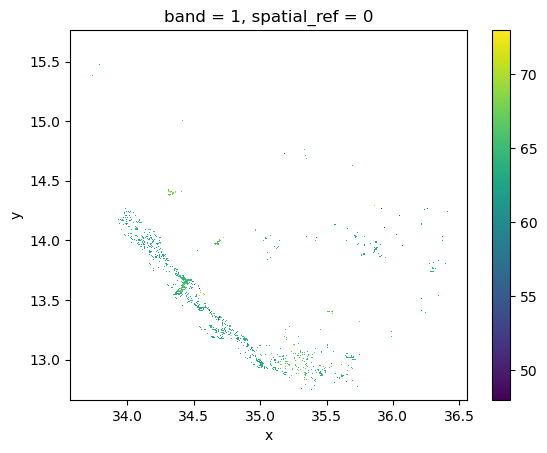

In [21]:
phe_dry_mos_img_s2 = rioxarray.open_rasterio(str(outdir / 'phenology' / 'L2_PHE_dry_MOS_S2.tif'))
phe_dry_mos_img_s2 = phe_dry_mos_img_s2.where(phe_dry_mos_img_s2 <= 108)
phe_dry_mos_img_s2.plot()
plt.show()

As you can see in the result above, there are few pixels in the study area having a second growing season.
In order to not make this exercise overly complex, we will ignore pixels with a second growing season.
Mask these pixels in the S1 MOS product:

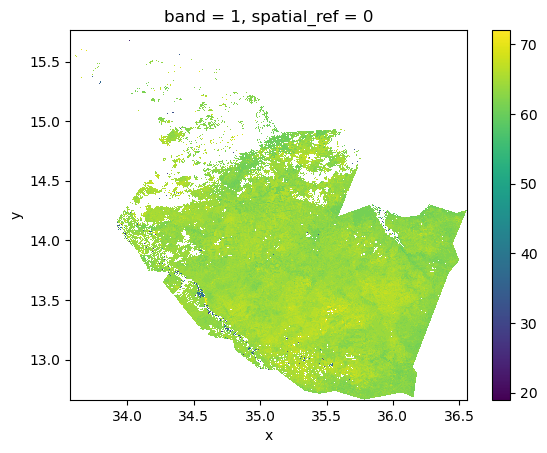

In [22]:
phe_dry_mos_img_s1 = rioxarray.open_rasterio(str(outdir / 'phenology' / 'L2_PHE_dry_MOS_S1.tif'))
phe_dry_mos_img_s1 = phe_dry_mos_img_s1.where(phe_dry_mos_img_s1 <= 108)
phe_dry_mos_img_s1 = phe_dry_mos_img_s1.where(np.isnan(phe_dry_mos_img_s2))
phe_dry_mos_img_s1.plot()
plt.show()

In [23]:
# check minimum and maximum values of MOS in the dry year:
print(np.nanmin(phe_dry_mos_img_s1.values))
print(np.nanmax(phe_dry_mos_img_s1.values))

19.0
72.0


/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/xarray/core/dataarray.py:3087: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  if not reflexive
/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/xarray/core/variable.py:2429: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


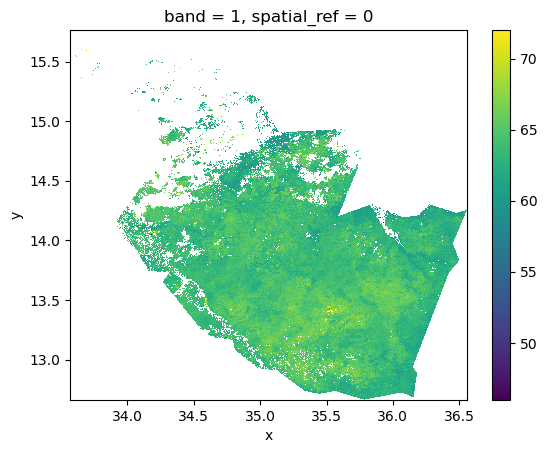

In [24]:
# note that some pixels have a peak of season which is outside of our year of interest (MOS < 36 or MOS > 72)
# for safety, we will exclude these pixels and also exclude pixels with MOS very early in the year from our analysis
phe_dry_mos_img_s1 = phe_dry_mos_img_s1.where(xr.ufuncs.logical_and(phe_dry_mos_img_s1 > 45, phe_dry_mos_img_s1 <= 72))
phe_dry_mos_img_s1.plot()
plt.show()

Now repeat these steps for the wet year as well...

QUESTION: can you already see a difference between the wet and dry year in terms of timing of MOS, caused by the drought? Please describe!

/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  
/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/xarray/core/dataarray.py:3087: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  if not reflexive
/home/jeroendegerickx/miniconda3/envs/eoafrica/lib/python3.7/site-packages/xarray/core/variable.py:2429: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


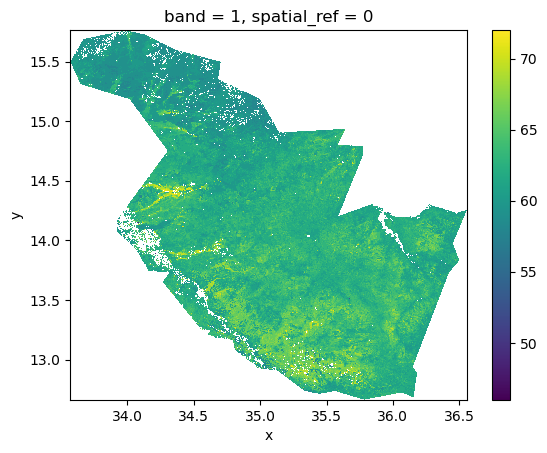

In [25]:
phe_wet_mos_img_s2 = rioxarray.open_rasterio(str(outdir / 'phenology' / 'L2_PHE_wet_MOS_S2.tif'))
phe_wet_mos_img_s2 = phe_wet_mos_img_s2.where(phe_wet_mos_img_s2 <= 108)
phe_wet_mos_img_s1 = rioxarray.open_rasterio(str(outdir / 'phenology' / 'L2_PHE_wet_MOS_S1.tif'))
phe_wet_mos_img_s1 = phe_wet_mos_img_s1.where(phe_wet_mos_img_s1 <= 108)
phe_wet_mos_img_s1 = phe_wet_mos_img_s1.where(np.isnan(phe_wet_mos_img_s2))
phe_wet_mos_img_s1 = phe_wet_mos_img_s1.where(xr.ufuncs.logical_and(phe_wet_mos_img_s1 > 45, phe_wet_mos_img_s1 <= 72))
phe_wet_mos_img_s1.plot()
plt.show()

## 5.3 Update LC mask based on phenology

Extend the LC mask with the pixels masked out in the previous step of the analysis (i.e. pixels having two growing seasons and/or no clear seasonality in our year of interest).

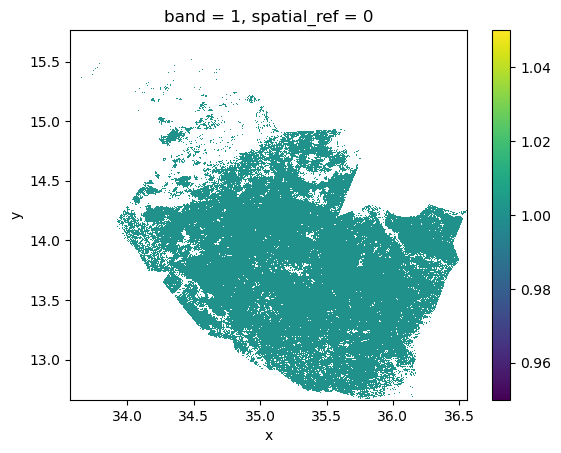

In [26]:
lcc_mask_dry = rioxarray.open_rasterio(str(outdir / 'LC' / 'L2_LCC_dry_masked.tif'))
lcc_mask_dry = lcc_mask_dry.where(~np.isnan(phe_dry_mos_img_s1.values))
lcc_mask_dry.plot()
plt.show()
outfile = str(outdir / 'LC' / 'L2_LCC_dry_masked_pheno.tif')
lcc_mask_dry.rio.to_raster(outfile)

Do the same for the wet year...

In [27]:
lcc_mask_wet = rioxarray.open_rasterio(str(outdir / 'LC' / 'L2_LCC_wet_masked.tif'))
lcc_mask_wet = lcc_mask_wet.where(~np.isnan(phe_wet_mos_img_s1.values))
outfile = str(outdir / 'LC' / 'L2_LCC_wet_masked_pheno.tif')
lcc_mask_wet.rio.to_raster(outfile)

## 5.3 Apply the updated mask to all phenology layers

Now we apply the extended land cover mask to the MOS data for season 1 in order to make sure pixels which we are not interested in, will not be processed in the future...

Meanwhile, we also make sure the phenology values range from 1 - 36 as we only focus on our year of interest...
You can make use of the function below to adjust the MOS of Season 1 for both the wet and dry years.

In [28]:
def mask_phenology(input_path, mask):
    '''
    Little function to execute a recurrent operation faster
    '''
    
    src = rioxarray.open_rasterio(input_path)
    src = src.where(~np.isnan(mask.values))
    src = src - 36
    output_path = input_path[:-4] + '_masked.tif'
    src.rio.to_raster(output_path)
    
    return src

Now apply that function:

In [29]:
infile = str(outdir / 'phenology' / 'L2_PHE_dry_MOS_S1.tif')
phe_dry_mos = mask_phenology(infile, lcc_mask_dry)

infile = str(outdir / 'phenology' / 'L2_PHE_wet_MOS_S1.tif')
phe_wet_mos = mask_phenology(infile, lcc_mask_wet)

# 6. Get mean VHI

We will now extract the Mean VHI for both years for our region of interest through the FAO map catalog...

## 6.1 Extract the mean VHI dekadal from the FAO map catalog

In [30]:
workspace = 'ASIS'
overview = False
paged = False
cubes_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp = requests.get(cubes_url).json()
catalog = pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,workspaceCode,dataType,index,operation,hidden,links,tags
0,PRO,Progress of Season,The indicator depicts the development of crops...,"{'flags': [{'value': 250, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
1,VHI_D,Vegetation Health Index (Dekadal),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
2,VHI_M,Vegetation Health Index (Monthly),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
3,HDF,Historic Drought Frequency,Historic Agricultural Drought Frenquecy Maps d...,"{'flags': [{'value': 251, 'description': 'inco...",ASIS,RASTER,1,"{'pixelTimeSeries': False, 'areaStats': False}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
4,ASI_A,Agricultural Stress Index (Annual),The Annual ASI depicts the percentage of arabl...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
5,ASI_D,"Agricultural Stress Index (Near Real Time, Dek...",The Agricultural Stress Index (ASI) is a quick...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
6,VCI_M,Vegetation Condition Index (Monthly),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
7,DI_A,Drought Intensity (Annual),Agricultural droughts are classified by their ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
8,VCI_D,Vegetation Condition Index (Dekadal),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
9,MVHI_A,Mean Vegetation Health Index (Annual),The Mean Vegetation Health Index (Mean VHI) al...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN


We are interested in the Mean Vegetation Health Index on dekadal scale. The mean VHI averages the VHI from start of the season 1 to the dekad given in the query payload. In order to download the right data we need to know the range of MOS in both the wet and dry years...

In [31]:
print('MOS min dry: ', np.nanmin(phe_dry_mos))
print('MOS max dry: ', np.nanmax(phe_dry_mos))
print('MOS min wet: ', np.nanmin(phe_wet_mos))
print('MOS max wet: ', np.nanmax(phe_wet_mos))

MOS min dry:  10.0
MOS max dry:  36.0
MOS min wet:  10.0
MOS max wet:  36.0


So basically we need to dowload data from dekad 10 onwards (month april) up till the end of the year...

In order to link the dekad number with the files to download, we can prepare the following list, thereby making sure the dekad is presented in the format expected by the API:

In [32]:
# dekad numbers range between 10 and 36
dekad_nr = list(range(10, 37))
years = [2015, 2018]
dekad_df = []

for year in years:
    dekad_list = []
    for month in range(4, 13):
        if month < 9:
            dekad_list.append(f'[{year}-0{month}-01,{year}-0{month}-11)')
            dekad_list.append(f'[{year}-0{month}-11,{year}-0{month}-21)')
            dekad_list.append(f'[{year}-0{month}-21,{year}-0{month+1}-01)')
        elif month == 9:
            dekad_list.append(f'[{year}-0{month}-01,{year}-0{month}-11)')
            dekad_list.append(f'[{year}-0{month}-11,{year}-0{month}-21)')
            dekad_list.append(f'[{year}-0{month}-21,{year}-{month+1}-01)')
        elif month == 12:
            dekad_list.append(f'[{year}-{month}-01,{year}-{month}-11)')
            dekad_list.append(f'[{year}-{month}-11,{year}-{month}-21)')
            dekad_list.append(f'[{year}-{month}-21,{year+1}-0{month-11}-01)')
        else:
            dekad_list.append(f'[{year}-{month}-01,{year}-{month}-11)')
            dekad_list.append(f'[{year}-{month}-11,{year}-{month}-21)')
            dekad_list.append(f'[{year}-{month}-21,{year}-{month+1}-01)')
            
    intermediate_dict = {'dekad_no': dekad_nr, 'dekad': dekad_list,
                         'year': [year] * len(dekad_nr)}
    dekad_df.append(pd.DataFrame(intermediate_dict))

dekad_df = pd.concat(dekad_df, axis=0, ignore_index=True)
dekad_df

,dekad_no,dekad,year
0,10,"[2015-04-01,2015-04-11)",2015
1,11,"[2015-04-11,2015-04-21)",2015
2,12,"[2015-04-21,2015-05-01)",2015
3,13,"[2015-05-01,2015-05-11)",2015
4,14,"[2015-05-11,2015-05-21)",2015
5,15,"[2015-05-21,2015-06-01)",2015
6,16,"[2015-06-01,2015-06-11)",2015
7,17,"[2015-06-11,2015-06-21)",2015
8,18,"[2015-06-21,2015-07-01)",2015
9,19,"[2015-07-01,2015-07-11)",2015


The following cell can take a while to execute, it is the ideal time to get a break and drink some coffee. 

In [79]:
for i, row in dekad_df.iterrows():
    
    year = row.year
    dekad_no = row.dekad_no
    dekad = row.dekad
    
    cube_code = 'MVHI_D'
    workspace = 'ASIS'
    outputFileName = f'MVHI_D_{year}_{dekad_no}.tif' # indicate how you want to name your rasterfile

    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']

    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])

    season = "S1"
    land = "C"     
    
    roifile = str(outdir / 'ROI.gpkg')
    roi = gpd.read_file(roifile)
    shape = json.loads(roi.geometry.to_json())['features'][0]['geometry']       

    query={
      "type": "CropRaster",
      "params": {
        "properties": {
          "outputFileName": outputFileName,
          "cutline": True,
          "tiled": True,
          "compressed": True,
          "overviews": True
        },
        "cube": {
          "code": cube_code,
          "workspaceCode": workspace,
          "language": "en"
        },
        "dimensions": [
          {
            "code": "DEKAD",
            "values": [
              dekad
            ]
          },
          {
            "code": "SEASON",
            "values": [
              season
            ]
          },
          {
            "code": "LAND",
            "values": [
              land
            ]
          }
        ],
        "measures": [
          measure
        ],
        "shape": shape
      }
    }
    
    # Get job url:
    resp_query = requests.post(path_query, headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                          json=query)
    resp_query = resp_query.json()
    job_url = resp_query['response']['links'][0]['href']
    
    # get download url :
    i = 0
    print('RUNNING', end=" ")
    while i == 0:        
        resp = requests.get(job_url)
        resp = resp.json()

        if resp['response']['status']=='RUNNING':
            print('.', end =" ")
        if resp['response']['status']=='COMPLETED':
            results=resp['response']['output']
            print(resp['response']['output'])
            i = 1
        if resp['response']['status']=='COMPLETED WITH ERRORS':
            print(resp['response']['log'])
            i = 1  

RUNNING . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/712ea81f-31d1-4847-9322-5f9cc63f942d/MVHI_D_2015_10.tif'}
RUNNING . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/c1ef954d-6e1f-4741-8802-5c50a6ee32cb/MVHI_D_2015_11.tif'}
RUNNING . . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/da8a31c5-3002-4d6a-a57a-567abae24939/MVHI_D_2015_12.tif'}
RUNNING . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/d29b3247-a91e-4d56-bbc8-153117e280bb/MVHI_D_2015_13.tif'}
RUNNING . . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/b0d273e6-1b87-4e9a-a927-e1cdd8d55bfa/MVHI_D_2015_14.tif'}
RUNNING . . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/77635ae0-2f95-48be-859c-2620c72b4bd9/MVHI_D_2015_15.tif'}
RUNN

Before we can work properly with the MVHI maps, we need to warp them so their resolution matches with the LC mask.

## 6.2 Warp MVHI

Again to optimize the workflow and automate the warping process a for loop is applied over all the files present in the inputfolder:

In [84]:
# define input_folder
input_folder = Path(r'./results/mvhi' )
# get list of tif files in the input_folder
input_fhs = sorted(glob.glob(str(input_folder / '*.tif'))) 

# define the file of which we want the projection/resolution (destination info):
dst_info = gdal.Info(gdal.Open(r'./results/phenology/L2_PHE_dry_MOS_S1_masked.tif'), format='json')

# define output folder:
output_folder = Path(r'./results/mvhi/warped')
# create output_folder if it does not exist
if not os.path.exists(output_folder): 
    os.makedirs(output_folder)
    
# loop over all files:
for input_fh in input_fhs:
    src_info = gdal.Info(gdal.Open(input_fh), format='json')
    filename = os.path.basename(input_fh)
    output_file = str(output_folder / filename[:-4] + '_warped.tif')
    
    output = gdal.Warp(output_file, input_fh, format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')
    # (use the following line to make sure the output is written to disk correctly)
    output = None

## 6.3 Compute MVHI for the region of interest

Now we want for each pixel the Mean VHI over the first half of the growing season. We simply need for each pixel the value of the MVHI which corresponds with the dekad at which the season peaks. This can be achieved by looping over the different dekads and assigning the right values to the right pixels.

In [7]:
def produce_mvhi(mos_ds, mvhi_dir, year, outfile):
    
    # define final result
    output = xr.zeros_like(mos_ds)
    
    # check which unique MOS values occur, ignoring NaN
    mos_val = list(np.unique(mos_ds.values[~np.isnan(mos_ds.values)]))
    
    for mos in mos_val:
        mos = int(mos)
        mvhi_mos = rioxarray.open_rasterio(str(mvhi_dir / f'MVHI_D_{year}_{mos}_warped.tif'))
        # get MVHI values where phe_dry_mos = dekad
        mask = np.where(mos_ds != mos, 0, mvhi_mos)
        # add to final result
        output = output + mask
    
    # make sure result contains NaN where MOS == np.NaN
    output = output.where(~np.isnan(mos_ds))
    # save to .tif file
    output.rio.to_raster(outfile)
    
    return output

Apply function to wet and dry year:

In [8]:
outfile = str(output_folder / 'Final_mvhi_dry.tif')
mvhi_dry = produce_mvhi(phe_dry_mos, output_folder, 2015, outfile)

outfile = str(output_folder / 'Final_mvhi_wet.tif')
mvhi_wet = produce_mvhi(phe_wet_mos, output_folder, 2018, outfile)

## 6.4 Classify MVHI values into drought severity classes

Our map represents continuous values of the Mean VHI. To simplify and convert them to a drought intensity map, we can reclass the array. The classes are based on [this FAO website](https://www.fao.org/giews/earthobservation/asis/index_1.jsp?lang=en).

- Class 1: MVHI < 0.25    : Extreme
- Class 2: MVHI 0.25-0.35 : Severe
- Class 3: MVHI 0.35-0.38 : Moderate 
- Class 4: MVHI 0.38-0.42 : Mild
- Class 5: MVHI 0.42-1    : None
- Class 6: MVHI > 1       : Insufficient data

In [9]:
def classify_drought(mvhi, outfile):
    
    # define output
    output = xr.zeros_like(mvhi)
    class1 = np.where((mvhi < 0.25) & (mvhi > 0), 1, output)
    class2 = np.where((mvhi < 0.35) & (mvhi >= 0.25), 2, output)
    class3 = np.where((mvhi < 0.38) & (mvhi >= 0.35), 3, output) 
    class4 = np.where((mvhi < 0.42) & (mvhi >= 0.38), 4, output) 
    class5 = np.where((mvhi <= 1) & (mvhi >= 0.42), 5, output) 
    class6 = np.where(mvhi > 1, 6, output) 
    
    output.values = class1 + class2 + class3 + class4 + class5 + class6
    output = output.where(output != 0)

    output.rio.to_raster(outfile)
    
    return output

Apply this function for both wet and dry years and plot the result...

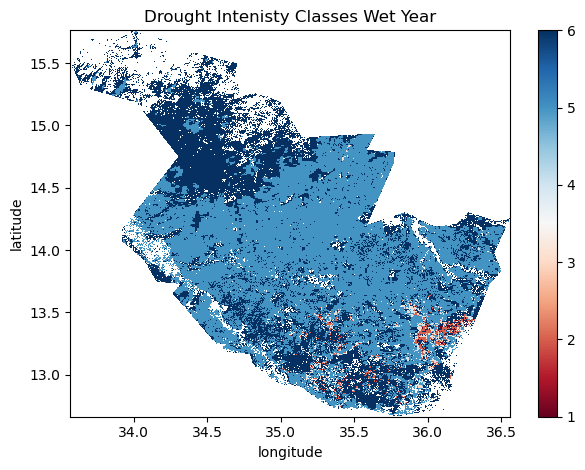

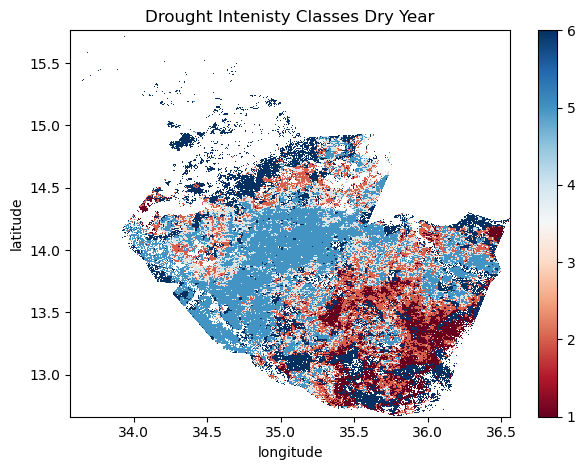

In [10]:
drought_dir = outdir / 'drought_severity'
drought_dir.mkdir(parents=True, exist_ok=True)

outfile = str(drought_dir / 'drought_wet.tif')
drought_wet = classify_drought(mvhi_wet, outfile)
drought_wet.plot(cmap="RdBu")
plt.title("Drought Intenisty Classes Wet Year")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.show()

outfile = str(drought_dir / 'drought_dry.tif')
drought_dry = classify_drought(mvhi_dry, outfile)
drought_dry.plot(cmap="RdBu")
plt.title("Drought Intenisty Classes Dry Year")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.show()

Now you can clearly see where specifically in the Gadaref province the impact of the drought is expected to be highest...

# 7. Calculate another drought index for this region

QUESTION: Based on the earlier exercises, compute another index which can show that indeed 2015 was remarkably drier compared to 2018 in this region.

Options covered during earlier exercises include the SPEI index, LST versus air temperature and precipitation versus evapotranspiration...


# 8. Impact of drought on vegetation

## 8.1 Net Primary Productivity throughout the season

Now let's zoom in on a specific location where the drought had highest impact according to our computed drought indicator...
Retrieve the NPP timeseries from the WaPOR data portal for the given location, for both the wet and dry years.

Location: [13.4712, 35.3531] (Lat, Lon)

Make use of the **get_pixel_timeseries** function from exercise 6.2.3.

In [33]:
def get_pixel_timeseries(workspace, product_code,
                         coordinates, crs,
                         start_date, end_date):
    '''
    Function to extract one or multiple pixel time series from the FAO portal.
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
    - coordinates: dictionary with keys representing label of the point
        and values the x,y coordinate pair in the CRS defined by the next parameter.
        In case of Geographic CRS, the order should be [lat, lon].
    - crs: EPSG code of projection system (int)
    - start_date: start date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
    - end_date: end date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
        
    The function will return a dataframe with time as index and each column
    representing the query result for an individual point.
    '''
    
    print('Making some preparations...')
    
    path_query = r'https://io.apps.fao.org/gismgr/api/v1/query/'
    
    crs = f'EPSG:{crs}'
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])
    dimension = items[items.type=='TIME']['code'].values[0]
    print('DIMENSION: ', dimension)
    
    print('Sending query for each point...')
    npoints = len(coordinates.keys())
    i = 0    
    for label, coo in coordinates.items():
        
        print(f'Processing point {i+1} / {npoints}...')
        query = {
        "type": "PixelTimeSeries",
        "params": {
            "cube": {
            "code": product_code,
            "workspaceCode": workspace,
            "language": "en"
            },
            "dimensions": [
            {
                "code": dimension,
                "range": f"[{start_date},{end_date})"
            }
            ],
            "measures": [
            measure
            ],
            "point": {
            "crs": crs,            
            "x":coo[1],
            "y":coo[0]
            }
        }
        }
        
        resp_query = requests.post(path_query, json=query)
        resp = resp_query.json()
        results = resp['response']
        df = pd.DataFrame(results['items'], columns=['Time', label])
        df.index = pd.to_datetime(df['Time'], format='%Y-%m-%d')
        df = df.drop(columns=['Time'])
        if i == 0:
            df_fin = df
        else:
            df_fin = pd.merge(df_fin, df, left_index=True, right_index=True)  
        
        i += 1
        print('Query successful!')
        
    return df_fin

In [34]:
# Specify parameters for API query
point = {'test': [13.4666, 35.3385]} 
crs = 4326
product_code = "L1_NPP_D"
workspace = 'WAPOR_2'
start_date_dry = "2015-01-01"
end_date_dry = "2015-12-31"
start_date_wet = "2018-01-01"
end_date_wet = "2018-12-31"

In [42]:
# Dry year
df_dry = get_pixel_timeseries(workspace, product_code,
                              point, crs,
                              start_date_dry, end_date_dry)
# add dekad number
df_dry['dekad'] = range(1, len(df_dry)+1)

# Wet year
df_wet = get_pixel_timeseries(workspace, product_code,
                              point, crs,
                              start_date_wet, end_date_wet)

# add dekad number
df_wet['dekad'] = range(1, len(df_wet)+1)

npp_df = pd.merge(df_dry, df_wet, left_on='dekad', right_on='dekad',
                  suffixes=('_dry', '_wet'))
npp_df.head()


Making some preparations...
MEASURE:  NPP
DIMENSION:  DEKAD
Sending query for each point...
Processing point 1 / 1...
Query successful!
Making some preparations...
MEASURE:  NPP
DIMENSION:  DEKAD
Sending query for each point...
Processing point 1 / 1...
Query successful!


,test_dry,dekad,test_wet
0,0.248,1,0.483
1,0.272,2,0.474
2,0.271,3,0.346
3,0.200,4,0.268
4,0.209,5,0.198


Now plot both timeseries in one graph.

QUESTION: Discuss how the drought had an impact on vegetation productivity for this specific location. Please include the plot in your answer to this question.

Text(0.5, 1.0, 'NPP time series example for dry and wet year')

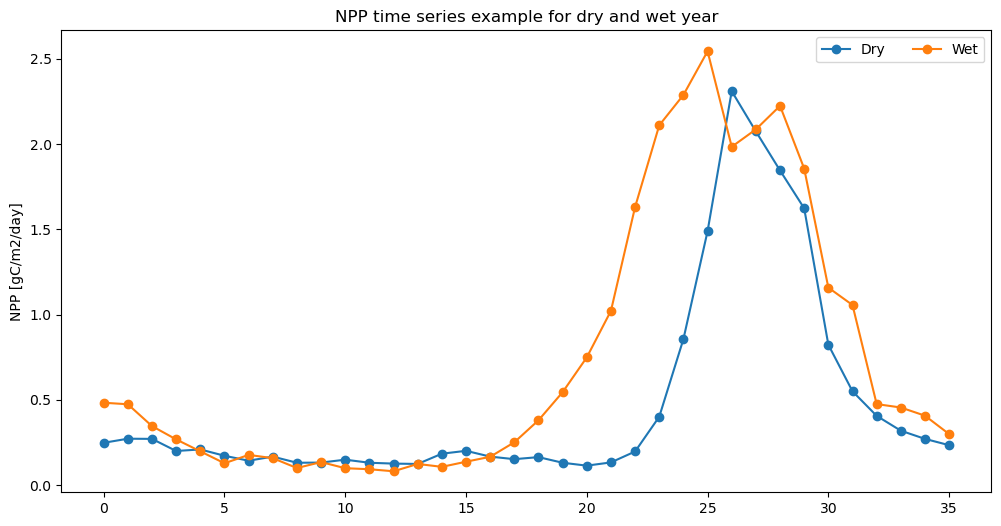

In [43]:
figs, ax = plt.subplots(1, figsize=(12, 6))

npp_df['test_dry'].plot(ax=ax,label='Dry', marker='o')
npp_df['test_wet'].plot(ax=ax,label='Wet', marker='o')

ax.set_ylabel('NPP [gC/m2/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('NPP time series example for dry and wet year')

## 8.2 Total Biomassa Production during the season

Let's now check the impact on total biomass production across the entire season, again for the location specified above.
Retrieve the Total Biomass Production product from the WaPOR data portal.

Since we now need a seasonal product, we need to adjust the **get_pixel_timeseries** function from exercise 6.2.3 a bit...

In [45]:
def get_pixel_seasonal_value(workspace, product_code,
                         coordinates, crs,
                         dimensions):
    '''
    Function to extract one or multiple pixel time series from the FAO portal.
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
    - coordinates: dictionary with keys representing label of the point
        and values the x,y coordinate pair in the CRS defined by the next parameter.
        In case of Geographic CRS, the order should be [lat, lon].
    - crs: EPSG code of projection system (int)
    - dimensions: specifies for which year, season etc. the product needs to be downloaded
        
    The function will return a dataframe with time as index and each column
    representing the query result for an individual point.
    '''
    
    print('Making some preparations...')
    
    path_query = r'https://io.apps.fao.org/gismgr/api/v1/query/'
    
    crs = f'EPSG:{crs}'
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])
    dimension = items[items.type=='TIME']['code'].values[0]
    print('DIMENSION: ', dimension)
    
    print('Sending query for each point...')
    npoints = len(coordinates.keys())
    i = 0    
    for label, coo in coordinates.items():
        
        print(f'Processing point {i+1} / {npoints}...')
        query = {
        "type": "PixelTimeSeries",
        "params": {
            "cube": {
            "code": product_code,
            "workspaceCode": workspace,
            "language": "en"
            },
            "dimensions": dimensions,
            "measures": [
            measure
            ],
            "point": {
            "crs": crs,            
            "x":coo[1],
            "y":coo[0]
            }
        }
        }
        
        resp_query = requests.post(path_query, json=query)
        resp = resp_query.json()
        results = resp['response']
        df = pd.DataFrame(results['items'], columns=['Time', label])
        df.index = pd.to_datetime(df['Time'], format='%Y-%m-%d')
        df = df.drop(columns=['Time'])
        if i == 0:
            df_fin = df
        else:
            df_fin = pd.merge(df_fin, df, left_index=True, right_index=True)  
        
        i += 1
        print('Query successful!')
        
    return df_fin

In [46]:
# Specify parameters for API query
point = {'test': [13.4666, 35.3385]} 
crs = 4326
product_code = "L2_TBP_S"
workspace = 'WAPOR_2'
year_dry = '[2015-01-01,2016-01-01)'
year_wet = '[2018-01-01,2019-01-01)'
season = "S1"

In [49]:
# Dry year
dimensions = [{"code": "YEAR",
               "values": [year_dry]},
              {"code": "SEASON",
               "values": [season]}]
tbp_dry = get_pixel_seasonal_value(workspace, product_code,
                              point, crs,
                              dimensions)

# Wet year
dimensions = [{"code": "YEAR",
               "values": [year_wet]},
              {"code": "SEASON",
               "values": [season]}]
tbp_wet = get_pixel_seasonal_value(workspace, product_code,
                              point, crs,
                              dimensions)

TBP_df = pd.concat([tbp_dry, tbp_wet], ignore_index=False)
TBP_df.index = ["Dry", "Wet"]
TBP_df

Making some preparations...
MEASURE:  LPR_S
DIMENSION:  YEAR
Sending query for each point...
Processing point 1 / 1...
Query successful!
Making some preparations...
MEASURE:  LPR_S
DIMENSION:  YEAR
Sending query for each point...
Processing point 1 / 1...
Query successful!


,test
Dry,3030.0
Wet,5510.0


Now plot the values in one bar graph for quick comparison.

QUESTION: Does this result confirm your earlier conclusion based on NPP? Doest this make sense, given how total biomass production in WaPOR is derived? Please include the plot in your answer to this question.

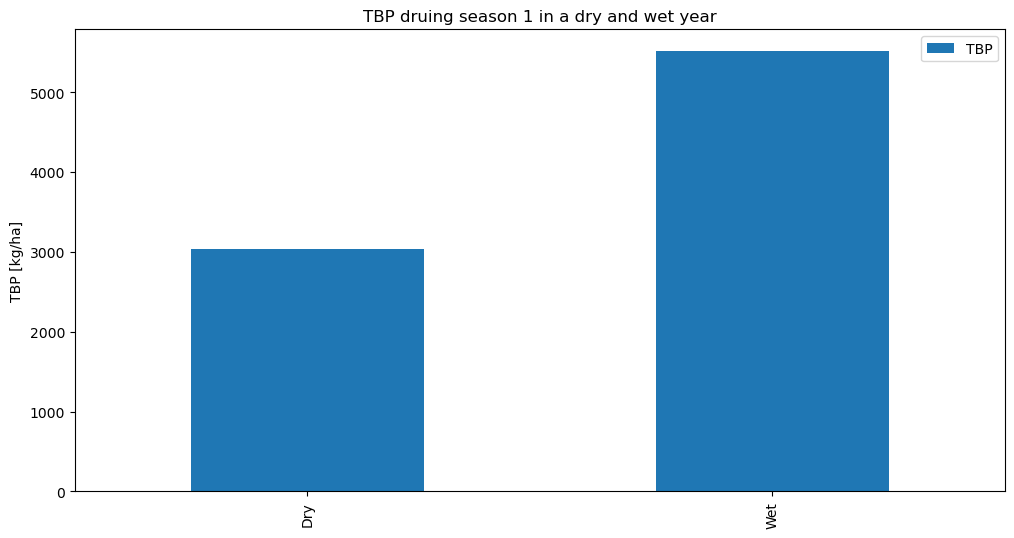

In [51]:

figs, ax = plt.subplots(1, figsize=(12, 6))
TBP_df['test'].plot.bar(ax=ax, label = 'TBP')
ax.set_ylabel('TBP [kg/ha]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('TBP druing season 1 in a dry and wet year')
plt.show()

# 9. How many people are affected by the drought? 

## 9.1 Get population count map

From the FAO catalog, retrieve the population count for our region of interest and for the dry year only.

Population count data is included in the "WPOP" dataset.

Make use of the **request_tif_files** function from exercise 6.2.3, but this time use the ROI shapefile as input for the function.

In [52]:
workspace = 'WPOP'
overview = False
paged = False
cubes_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp = requests.get(cubes_url).json()
catalog = pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,WPOP_T,Total Population,Estimated total number of people per grid-cell...,"{'format': 'Raster Dataset', 'unit': 'ppl', 'd...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,1,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,WPOP_D,Human Population Density,Estimated density of people per grid-cell. The...,"{'format': 'Raster Dataset', 'unit': 'ppl/Km²'...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,2,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


In [53]:
product_code = 'WPOP_T'

# Specify years
years = {'dry': '[2015-01-01,2016-01-01)'}

# specify output directory
wpop_dir = outdir / 'wpop'
wpop_dir.mkdir(exist_ok=True, parents=True)

for label, year in years.items():
    dimensions = [{"code": "YEAR",
               "values": [year]}]
    outputfilename = f'WPOP_count_{label}.tif'
    output = request_tif_files(workspace, product_code,
                               crs, outputfilename,
                               dimensions, shapefile=roifile,
                               labelcol=labelcol)
    print(output)

MEASURE:  PPL_T
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/401178e3-73b6-4776-aecd-4f3c635e8a17/WPOP_count_dry.tif']


Download the files and upload them into a wpop folder in your output directory

## 9.2 Warp the population data to the resolution of our drought analysis

In [32]:
# define the file of which we want the projection/resolution (destination info):
dst_info = gdal.Info(gdal.Open(r'./results/mvhi/warped/Final_mvhi_dry.tif'), format='json')

wpopfile = str(wpop_dir / 'WPOP_count_dry.tif')
src_info = gdal.Info(gdal.Open(wpopfile), format='json')
filename = os.path.basename(wpopfile)
output_file = str(wpop_dir / (filename[:-4] + '_warped.tif'))
    
output = gdal.Warp(output_file, wpopfile, format='GTiff',
          srcSRS=src_info['coordinateSystem']['wkt'],   
          dstSRS=dst_info['coordinateSystem']['wkt'],  
          srcNodata=src_info['bands'][0]['noDataValue'],
          dstNodata=src_info['bands'][0]['noDataValue'],   
          width=dst_info['size'][0],
          height=dst_info['size'][1],
          outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],              
                        dst_info['cornerCoordinates']['lowerLeft'][1],
                        dst_info['cornerCoordinates']['upperRight'][0],
                        dst_info['cornerCoordinates']['upperRight'][1]),
          outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
          resampleAlg='near')
output = None

WPOP_T data represents a people count per pixel. When warping and adjusting the pixel size, this needs to be accounted for. You can quickly calculate a conversion factor based on the sizes of the arrays, as they both represent the exact same area:

In [51]:
WPOP_arr = rioxarray.open_rasterio(wpopfile)
WPOP_pixcount = len(WPOP_arr['y']) * len(WPOP_arr['x'])
print(WPOP_pixcount)

drought_arr = rioxarray.open_rasterio('./results/drought_severity/drought_dry.tif')
drought_pixcount = len(drought_arr['y']) * len(drought_arr['x'])
print(drought_pixcount)

conversion = drought_pixcount / WPOP_pixcount
print(conversion)

134280
9418750
70.14261245159368


Apply the conversion factor to the data and get the people count where the drought was extreme or severe.

Make sure to first filter the WPOP data to get rid of the nodata value!

In [55]:
WPOP_tot = rioxarray.open_rasterio(output_file)
nodata = -9999
WPOP_tot = WPOP_tot.where(WPOP_tot != nodata)
WPOP_tot = WPOP_tot / conversion

WPOP_count_arr = np.where((drought_arr.values != 1) & (drought_arr.values != 2), 0, WPOP_tot.values)

total_people = int(np.nansum(WPOP_tot))
people_affected = int(np.nansum(WPOP_count_arr))
print(f'In total {people_affected} people were directly affected by this drought, in a region occupied by a total of {total_people} inhabitants.')

In total 221250 people were directly affected by this drought, in a region occupied by a total of 1398764 inhabitants!
